## Time Series Forecating of Samll Size Data
Done as part of submission to Barclays Challenge. No fancy methods were allowed to be used and this is my original approach.
Will keep improving further
### Data:
* Training: 1st Jan 2016 to 1st Jan 2018 of MSFT stock prices
* Test: 1st Jan 2018 to 1st July 2018

### Importing Libraries:
1. pandas for reading and operating on the dataframe
2. matplotlib for visualizations
2. numpy for mathematical operations

In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import svm, linear_model

In [98]:
df = pd.read_csv("./MSFT.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-31,56.040001,56.189999,55.419998,55.480000,52.144402,27334100
1,2016-01-04,54.320000,54.799999,53.389999,54.799999,51.505280,53778000
2,2016-01-05,54.930000,55.389999,54.540001,55.049999,51.740250,34079700
3,2016-01-06,54.320000,54.400002,53.639999,54.049999,50.800369,39518900
4,2016-01-07,52.700001,53.490002,52.070000,52.169998,49.033405,56564900


### Approach:

First order differences are found and averages over a month as well as a year are found. This is done to account for fluctuations. 
The features obtained are regressed

In [145]:
dhi = np.diff(df['High'])
dlo = np.diff(df['Low'])
dcl = np.diff(df['Close'])
dop = np.diff(df['Open'])
dad = np.diff(df['Adj Close'])

In [146]:
mop = np.transpose([np.average(dop[i-20:i]) for i in range(len(df))])
wop = np.transpose([np.average(dop[i-5:i]) for i in range(len(df))])
mop = np.nan_to_num(mop,0)
wop = np.nan_to_num(wop,0)

In [147]:
mcl = np.transpose([np.average(dcl[i-20:i]) for i in range(len(df))])
wcl = np.transpose([np.average(dcl[i-5:i]) for i in range(len(df))])
mcl = np.nan_to_num(mcl,0)
wcl = np.nan_to_num(wcl,0)

In [148]:
mhi = np.transpose([np.average(dhi[i-20:i]) for i in range(len(df))])
whi = np.transpose([np.average(dhi[i-5:i]) for i in range(len(df))])
mhi = np.nan_to_num(mhi,0)
whi = np.nan_to_num(whi,0)

In [149]:
mlo = np.transpose([np.average(dlo[i-20:i]) for i in range(len(df))])
wlo = np.transpose([np.average(dlo[i-5:i]) for i in range(len(df))])
mlo = np.nan_to_num(mlo,0)
wlo = np.nan_to_num(wlo,0)

In [150]:
mad = np.transpose([np.average(dad[i-20:i]) for i in range(len(df))])
wad = np.transpose([np.average(dad[i-5:i]) for i in range(len(df))])
mad = np.nan_to_num(mad,0)
wad = np.nan_to_num(wad,0)

In [151]:
X_train = np.array([mcl, wcl, mop, wop, mad, wad, mhi, whi, mlo, wlo]).transpose()
X_train.shape

(504, 10)

In [152]:
y_train = df['Adj Close']
last = y_train[len(y_train)-1]
av = np.average(y_train)

In [153]:
df2 = pd.read_csv('MSFT_test.csv')

In [154]:
clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [155]:
window = 20
predictions = []

for t in range(len(X_train),len(X_train)+len(df2)):
    mad = np.append(mad,np.mean(mad[t-window:t])+np.std(mad[t-window:t]))
    mcl = np.append(mcl,np.mean(mad[t-window:t])+np.std(mad[t-window:t]))
    mlo = np.append(mlo,np.mean(mad[t-window:t])+np.std(mad[t-window:t]))
    mhi = np.append(mhi,np.mean(mad[t-window:t])+np.std(mad[t-window:t]))
    mop = np.append(mop,np.mean(mad[t-window:t])+np.std(mad[t-window:t]))
    wad = np.append(wad,np.mean(wad[t-window//4:t])+np.std(mad[t-window//4:t]))
    wcl = np.append(wcl,np.mean(wad[t-window//4:t])+np.std(mad[t-window//4:t]))
    wlo = np.append(wlo,np.mean(wad[t-window//4:t])+np.std(mad[t-window//4:t]))
    whi = np.append(whi,np.mean(wad[t-window//4:t])+np.std(mad[t-window//4:t]))
    wop = np.append(wop,np.mean(wad[t-window//4:t])+np.std(mad[t-window//4:t]))
    X_test = np.array([mcl, wcl, mop, wop, mad, wad, mhi, whi, mlo, wlo]).transpose()
    y_hat = (last/av)*clf.predict(X_test[len(X_train):])
    #y_hat = (X_test[t-1]//np.average(X_test[t-100:t]))*clf.predict(X_test[t].reshape(10,1))
    
history = df2['Adj Close']

In [156]:
error = np.sqrt(np.average(np.array(df2['Adj Close'])-y_hat)**2)
print(error)

1.8561433165771068


In [157]:
inc = [0]
for i in range(1,len(y_hat)):
    if(y_hat[i]>y_hat[i-1]):
        inc.append(1)
    elif(y_hat[i]<y_hat[i-1]):
        inc.append(-1)
    else:
        inc.append(0)

In [158]:
chg = [0]
for i in range(1,len(history)):
    if(history[i]>history[i-1]):
        chg.append(1)
    elif(history[i]<history[i-1]):
        chg.append(-1)
    else:
        chg.append(0)

In [159]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(chg,inc))


[[16  0 38]
 [ 0  1  1]
 [13  0 56]]


In [160]:
chg1 = np.array(chg)
np.place(chg1,chg1==0,-1)
inc1 = np.array(inc)
np.place(inc1,inc1==0,-1)
f1p = f1_score(chg1,inc1)
print(f1p)

chg2 = np.array(chg)
np.place(chg2,chg2==0,1)
inc2 = np.array(inc)
np.place(inc2,inc2==0,1)
f2p = f1_score(chg2,inc2)
print(f2p)

print("Average f1 Score:"+str((f1p+f2p)/2))

0.6829268292682926
0.6946107784431137
Average f1 Score:0.6887688038557032


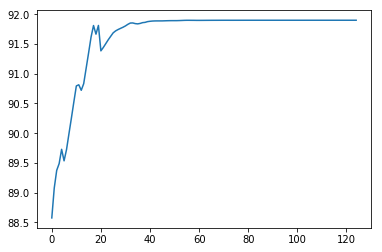

In [161]:
plt.plot(y_hat)

In [31]:
y_hat

array([88.57615184, 89.07811941, 89.37506627, 89.48955952, 89.72914105,
       89.53555645, 89.72450076, 89.99336626, 90.2571549 , 90.52937885,
       90.79462172, 90.81385413, 90.72118442, 90.8326454 , 91.09261529,
       91.35124655, 91.61651542, 91.80965139, 91.66480723, 91.81131025,
       91.38423583, 91.44162903, 91.50581722, 91.57037135, 91.62878982,
       91.68647028, 91.71949979, 91.74237639, 91.76189374, 91.78073682,
       91.8029103 , 91.83020398, 91.85163493, 91.85303678, 91.84209435,
       91.83767763, 91.84533223, 91.85830888, 91.86279986, 91.87535048,
       91.8810495 , 91.88518251, 91.88699335, 91.88747464, 91.88754541,
       91.88772807, 91.88913255, 91.89053154, 91.89148315, 91.89189805,
       91.89188494, 91.89209913, 91.89335692, 91.89510886, 91.89680811,
       91.89787415, 91.89784404, 91.89735047, 91.89715761, 91.89644579,
       91.89642271, 91.89659511, 91.89688962, 91.89719944, 91.8974804 ,
       91.89770379, 91.89784982, 91.89799046, 91.89814046, 91.89